In [1]:
from google.colab import drive
drive.mount('/content/drive')

save_base_path = "/content/drive/MyDrive/MoE"

Mounted at /content/drive


# MoE based GPT 2

## Import Dependencies

In [2]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset, Dataset
from typing import Optional
import copy
import os
import json
from typing import Callable, Iterable, Tuple
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import csv
from tqdm import tqdm
from google.colab import userdata

hf_token = userdata.get('hf')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## MoE Router Module

In [3]:
import torch.nn.functional as F

class TopKRouter(nn.Module):
    def __init__(self, hidden_size: int, num_experts: int, top_k: int = 1):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(hidden_size, num_experts, bias=False)

        # 1. Initialization (Standard deviation 0.02 is correct)
        torch.nn.init.normal_(self.gate.weight, mean=0.0, std=0.02)

    def forward(self, hidden_states):
        # hidden_states: [batch, seq, hidden]
        batch_size, seq_len, _ = hidden_states.shape

        logits = self.gate(hidden_states)

        # 2. Router Jitter (CRITICAL for Top-1 Exploration)
        if self.training:
            # Inject noise to force exploration
            noise = torch.rand_like(logits) # Uniform [0, 1)
            logits = logits + (noise * 5e-2)

        # 3. Calculate Routings
        routing_weights = F.softmax(logits, dim=-1)

        # Get top-k
        top_k_weights, top_k_indices = torch.topk(routing_weights, self.top_k, dim=-1)

        # 4. Load Balancing Loss (Optimized)
        # P_i: Mean probability per expert
        prob_per_expert = routing_weights.mean(dim=(0, 1))

        # f_i: Fraction of tokens per expert (using bincount for speed)
        indices_flat = top_k_indices.view(-1)
        expert_counts = torch.bincount(indices_flat, minlength=self.num_experts)
        fraction_per_expert = expert_counts.float() / indices_flat.numel()

        # Switch Transformer Loss Formula
        lb_loss = self.num_experts * torch.sum(fraction_per_expert * prob_per_expert)

        # 5. Router Z-Loss (CRITICAL for Stability)
        # Penalizes large positive logits
        z_loss = torch.mean(torch.logsumexp(logits, dim=-1)**2)

        # 6. Return values
        # IMPORTANT: We return a dict so the MoELayer can weight them separately
        loss_dict = {'lb_loss': lb_loss, 'z_loss': z_loss}

        # IMPORTANT: Do NOT normalize top_k_weights to 1.0.
        # Keep the raw probability (e.g. 0.45) to scale the expert output.
        return top_k_weights, top_k_indices, logits, loss_dict

## MoE Layer

In [4]:
class MoELayer(nn.Module):
    """Mixture of Experts layer replacing the MLP"""
    def __init__(self, dense_mlp, num_experts: int = 8, top_k: int = 4,
                 drop_ratio: float = 0.0,
                 load_balance_weight: float = 0.01,
                 z_loss_weight: float = 1e-3):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.load_balance_weight = load_balance_weight
        self.z_loss_weight = z_loss_weight

        hidden_size = dense_mlp.c_fc.weight.shape[0]
        self.router = TopKRouter(hidden_size, num_experts, top_k)

        self.experts = nn.ModuleList([
            self._copy_mlp_with_drop(dense_mlp, drop_ratio) for _ in range(num_experts)
        ])

        self.aux_loss = 0.0

    def _copy_mlp_with_drop(self, dense_mlp, drop_ratio: float):
        expert = copy.deepcopy(dense_mlp)
        if drop_ratio > 0:
            with torch.no_grad():
                for name, param in expert.named_parameters():
                    mask = torch.rand_like(param) < drop_ratio
                    if mask.any():
                        param.data[mask] = torch.randn_like(param[mask]) * 0.02
        return expert

    def forward(self, hidden_states):
        batch_size, seq_len, hidden_size = hidden_states.shape
        total_tokens = batch_size * seq_len

        top_k_weights, top_k_indices, router_logits, loss_dict = self.router(hidden_states)

        # 0.01 * Balance Loss
        lb_loss = loss_dict['lb_loss'] * self.load_balance_weight
        # 0.001 * Z-Loss
        z_loss  = loss_dict['z_loss']  * self.z_loss_weight

        # Sum them for the trainer
        self.aux_loss = lb_loss + z_loss

        # --- Dispatch Logic (Standard) ---
        flat_hidden = hidden_states.view(total_tokens, hidden_size)
        flat_weights = top_k_weights.view(total_tokens, self.top_k)
        flat_indices = top_k_indices.view(total_tokens, self.top_k)

        output = torch.zeros_like(flat_hidden)

        flat_indices_1d = flat_indices.view(-1)
        flat_weights_1d = flat_weights.view(-1)

        token_indices = torch.arange(total_tokens, device=hidden_states.device)
        token_indices = token_indices.unsqueeze(1).expand(-1, self.top_k).reshape(-1)

        for expert_idx in range(self.num_experts):
            expert_mask = (flat_indices_1d == expert_idx)
            if not expert_mask.any():
                continue

            expert_token_indices = token_indices[expert_mask]
            expert_weights = flat_weights_1d[expert_mask]
            expert_input = flat_hidden[expert_token_indices]

            expert_output = self.experts[expert_idx](expert_input)
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            output.index_add_(0, expert_token_indices, weighted_output)

        output = output.view(batch_size, seq_len, hidden_size)

        return output

In [5]:
def calculate_active_params(model):
    """Calculate total parameters and active parameters in MoE layers"""
    total_params = sum(p.numel() for p in model.parameters())

    # Calculate MoE-specific info
    moe_info = {
        'total_experts': 0,
        'active_per_token': 0,
        'total_expert_params': 0,
        'active_expert_params': 0,
    }

    for name, module in model.named_modules():
        if isinstance(module, MoELayer):
            moe_info['total_experts'] += module.num_experts
            moe_info['active_per_token'] += module.top_k

            # Count expert parameters
            expert_params = sum(p.numel() for p in module.experts.parameters())
            moe_info['total_expert_params'] += expert_params
            moe_info['active_expert_params'] += (expert_params / module.num_experts) * module.top_k

    return total_params, moe_info

## Upcycle GPT2 Vanilla Weights to MoE Architecture

In [6]:
def upcycle_gpt2_to_moe(
    model_name: str = 'gpt2',
    num_experts: int = 8,
    top_k: int = 2,
    moe_layers: Optional[list] = None,
    drop_ratio: float = 0.05,
    match_active_params: bool = False,
    load_balance_weight: float = 0.01
):
    """
    Convert a standard GPT-2 model to MoE architecture
    """
    # Load the pre-trained model with LM head
    model = GPT2LMHeadModel.from_pretrained(model_name)
    original_params = sum(p.numel() for p in model.parameters())

    # If no specific layers specified, convert all layers
    if moe_layers is None:
        moe_layers = list(range(len(model.transformer.h)))

    # Auto-adjust for fair comparison
    if match_active_params:
        top_k = 1
        print(f"Fair comparison mode: Setting top_k={top_k} to match vanilla GPT-2 active params")

    upcycle_type = "Drop-Upcycling" if drop_ratio > 0 else "Standard Upcycling"
    print(f"Converting layers {moe_layers} to MoE with {num_experts} experts (top-{top_k})")
    print(f"Using {upcycle_type}" + (f" with {drop_ratio*100}% parameter re-initialization" if drop_ratio > 0 else ""))

    # Replace MLPs with MoE layers
    for layer_idx in moe_layers:
        if layer_idx >= len(model.transformer.h):
            print(f"Warning: Layer {layer_idx} doesn't exist, skipping")
            continue

        original_mlp = model.transformer.h[layer_idx].mlp

        model.transformer.h[layer_idx].mlp = MoELayer(
            original_mlp,
            num_experts=num_experts,
            top_k=top_k,
            drop_ratio=drop_ratio,
            load_balance_weight=load_balance_weight
        )

        print(f"Converted layer {layer_idx}")

    # Print parameter comparison
    total_params, moe_info = calculate_active_params(model)
    print("\n" + "=" * 60)
    print("PARAMETER COMPARISON")
    print("=" * 60)
    print(f"Original model params:        {original_params:,}")
    print(f"MoE model total params:       {total_params:,}")
    print(f"MoE model active params:      {int(original_params + moe_info['active_expert_params']):,}")
    print(f"\nPer-layer breakdown:")
    print(f"  Experts per layer:          {num_experts}")
    print(f"  Active experts per token:   {top_k}")
    print(f"  Active ratio:               {top_k}/{num_experts} = {top_k/num_experts:.1%}")

    if match_active_params:
        print(f"\nFair comparison mode: Active params ≈ vanilla GPT-2")
    else:
        active_ratio = (original_params + moe_info['active_expert_params']) / original_params
        print(f"\nMoE has {active_ratio:.1f}x active parameters vs vanilla")

    return model

In [7]:
def save_moe_model(model, save_path):
    """Save MoE model with custom layers"""
    os.makedirs(save_path, exist_ok=True)

    # Save model state dict
    torch.save(model.state_dict(), os.path.join(save_path, 'pytorch_model.bin'))

    # Save config
    model.config.save_pretrained(save_path)

    # Save MoE configuration
    moe_config = {
        'moe_layers': [],
        'num_experts': None,
        'top_k': None,
    }

    for layer_idx, layer in enumerate(model.transformer.h):
        if isinstance(layer.mlp, MoELayer):
            moe_config['moe_layers'].append(layer_idx)
            if moe_config['num_experts'] is None:
                moe_config['num_experts'] = layer.mlp.num_experts
                moe_config['top_k'] = layer.mlp.top_k

    with open(os.path.join(save_path, 'moe_config.json'), 'w') as f:
        json.dump(moe_config, f)

    print(f"Model saved to {save_path}")

In [8]:
def load_moe_model(load_path, device='cuda'):
    """Load MoE model with custom layers"""
    # Load MoE config
    with open(os.path.join(load_path, 'moe_config.json'), 'r') as f:
        moe_config = json.load(f)

    # Load base model
    base_model = GPT2LMHeadModel.from_pretrained('gpt2')

    # Convert to MoE architecture
    for layer_idx in moe_config['moe_layers']:
        original_mlp = base_model.transformer.h[layer_idx].mlp
        base_model.transformer.h[layer_idx].mlp = MoELayer(
            original_mlp,
            num_experts=moe_config['num_experts'],
            top_k=moe_config['top_k'],
            drop_ratio=0.0
        )

    # Load trained weights
    state_dict = torch.load(os.path.join(load_path, 'pytorch_model.bin'), map_location=device)
    base_model.load_state_dict(state_dict)
    base_model.to(device)

    print(f"Model loaded from {load_path}")
    return base_model

In [ ]:
moe_model = upcycle_gpt2_to_moe(
        model_name='gpt2',
        num_experts=8,
        top_k=1,
        drop_ratio=0.15,
        load_balance_weight=0.01,
        match_active_params=True,
        moe_layers=[1, 3, 5, 7, 9, 11],
    )

save_moe_model(moe_model, f'{save_base_path}/gpt2-moe-upcycled')

del moe_model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Fair comparison mode: Setting top_k=1 to match vanilla GPT-2 active params
Converting layers [1, 3, 5, 7, 9, 11] to MoE with 8 experts (top-1)
Using Drop-Upcycling with 15.0% parameter re-initialization
Converted layer 1
Converted layer 3
Converted layer 5
Converted layer 7
Converted layer 9
Converted layer 11

PARAMETER COMPARISON
Original model params:        124,439,808
MoE model total params:       322,818,816
MoE model active params:      152,774,400

Per-layer breakdown:
  Experts per layer:          8
  Active experts per token:   1
  Active ratio:               1/8 = 12.5%

Fair comparison mode: Active params ≈ vanilla GPT-2
Model saved to /content/drive/MyDrive/MoE/gpt2-moe-upcycled


## Finetune MoE Model

In [9]:
class MoETrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)

        if isinstance(outputs, dict):
            lm_loss = outputs['loss']
        else:
            lm_loss = outputs[0]

        total_aux_loss = 0.0

        # Calculate aux loss
        for name, module in model.named_modules():
            if hasattr(module, 'aux_loss'):
                 # Ensure it's a tensor (handle cases where it might be 0.0 float)
                loss_val = module.aux_loss
                if isinstance(loss_val, float):
                    loss_val = torch.tensor(loss_val, device=lm_loss.device)
                total_aux_loss += loss_val

        total_loss = lm_loss + total_aux_loss

        return (total_loss, outputs) if return_outputs else total_loss

def finetune_moe_model(
    moe_model_path: str = f'{save_base_path}/gpt2-moe-upcycled',
    output_dir: str = f'{save_base_path}/gpt2-moe-finetuned',
    num_train_steps: int = 5000,
    batch_size: int = 4,
    learning_rate: float = 1e-4,
    warmup_steps: int = 200,
    gradient_accumulation_steps: int = 8,
    save_steps: int = 1000,
    max_length: int = 512,
):
    """
    Fine-tune the upcycled MoE model
    """
    print("=" * 60)
    print("FINE-TUNING MoE MODEL")
    print("=" * 60)

    # Load the model using custom loader
    print(f"Loading model from {moe_model_path}...")
    model = load_moe_model(moe_model_path)

    print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Load tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    print(f"\nLoading dataset...")
    dataset = load_dataset('allenai/c4', 'en', split='train', streaming=True, token=hf_token)
    dataset = dataset.shuffle(seed=1337, buffer_size=1000).take(3_000_000)

    # Tokenize dataset
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=max_length,
            padding=False,
            return_tensors=None,
        )

    print("Tokenizing dataset...")
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['text', 'timestamp', 'url']
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        max_steps=num_train_steps,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        warmup_steps=312,
        lr_scheduler_type='cosine',
        max_grad_norm=0.5,
        fp16=False,

        save_strategy='epoch',
        save_total_limit=3,
        logging_steps=10,
        logging_first_step=True,
        dataloader_num_workers=2,
        remove_unused_columns=False,
        report_to='none',
    )

    # Create trainer
    trainer = MoETrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator,
    )

    # Train
    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Total steps: {num_train_steps}")
    print(f"Effective batch size: {batch_size * gradient_accumulation_steps}")
    print(f"Learning rate: {learning_rate}")
    print(f"Warmup steps: {warmup_steps}\n")

    trainer.train()

    print("\n" + "=" * 60)
    print("SAVING FINAL MODEL")
    print("=" * 60)
    save_moe_model(model, output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved to {output_dir}")

    return model

In [ ]:
finetuned_model = finetune_moe_model(
        moe_model_path=f'{save_base_path}/gpt2-moe-finetuned-half',
        output_dir=f'{save_base_path}/gpt2-moe-finetuned',
        num_train_steps=9766,
        batch_size=64,
        gradient_accumulation_steps=4,
        learning_rate=5e-5,
        warmup_steps=500,
    )

print("Successfully fintetuned model at folder gpt2-moe-fintuned")

del finetuned_model

FINE-TUNING MoE MODEL
Loading model from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-half...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-half
Model loaded with 322,818,816 parameters


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing dataset...

STARTING TRAINING
Total steps: 9766
Effective batch size: 256
Learning rate: 5e-05
Warmup steps: 500



`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,14.142600
10,14.173800
20,14.276300
30,14.297300
40,14.323500
50,14.267300
60,14.296400
70,14.308400
80,14.380900
90,14.282000



SAVING FINAL MODEL
Model saved to /content/drive/MyDrive/MoE/gpt2-moe-finetuned
Model and tokenizer saved to /content/drive/MyDrive/MoE/gpt2-moe-finetuned
Successfully fintetuned model at folder gpt2-moe-fintuned


## MoE Base Model Sanity Check

In [ ]:
from torch.utils.data import DataLoader
import math

finetuned_model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned', DEVICE)
finetuned_model.eval()
tokenizer = GPT2Tokenizer.from_pretrained(f'{save_base_path}/gpt2-moe-finetuned')
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset('allenai/c4', 'en', split='validation', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10).take(1000)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None,
    )

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text', 'timestamp', 'url']
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

val_loader = DataLoader(
    tokenized_dataset,
    batch_size=1,
    collate_fn=data_collator
)

total_loss = 0.0
total_steps = 0
total_correct = 0
total_tokens = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = finetuned_model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = batch["labels"][..., 1:].contiguous()

        predictions = torch.argmax(shift_logits, dim=-1)

        mask = shift_labels != -100

        correct = (predictions == shift_labels) & mask

        total_correct += correct.sum().item()
        total_tokens += mask.sum().item()
        total_loss += loss.item()
        total_steps += 1

avg_loss = total_loss / total_steps
perplexity = math.exp(avg_loss) if avg_loss < 100 else float('inf')
accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0

print("\n" + "-" * 30)
print(f"Validation Loss: {avg_loss:.4f}")
print(f"Perplexity:      {perplexity:.2f}")
print(f"Token Accuracy:  {accuracy:.2%}")
print("-" * 30)

del finetuned_model
del tokenizer

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing dataset...


Validating: 1000it [00:32, 31.03it/s]


------------------------------
Validation Loss: 3.4327
Perplexity:      30.96
Token Accuracy:  38.23%
------------------------------


In [ ]:
import torch.nn.functional as F

model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned', device='cuda')

def check_expert_similarity(model):
    print(f"{'Layer':<10} | {'Pair':<15} | {'Cosine Similarity':<20} | {'Status'}")
    print("-" * 65)

    for layer_idx, layer in enumerate(model.transformer.h):
        if not isinstance(layer.mlp, MoELayer):
            continue

        # Get the experts
        experts = layer.mlp.experts
        num_experts = len(experts)

        # We'll check similarity between Expert 0 and the others
        # Flatten weights for comparison: [hidden_size * intermediate_size]
        w_0 = experts[0].c_fc.weight.flatten()

        for i in range(1, num_experts):
            w_i = experts[i].c_fc.weight.flatten()

            # Compute Cosine Similarity
            similarity = F.cosine_similarity(w_0.unsqueeze(0), w_i.unsqueeze(0)).item()

            status = "DIVERGED (Good)" if similarity < 0.95 else "REDUNDANT (Bad)"
            print(f"{layer_idx:<10} | {'0 vs ' + str(i):<15} | {similarity:.4f}               | {status}")

# Run the check
check_expert_similarity(model)

del model
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned
Layer      | Pair            | Cosine Similarity    | Status
-----------------------------------------------------------------
1          | 0 vs 1          | 0.8461               | DIVERGED (Good)
1          | 0 vs 2          | 0.8463               | DIVERGED (Good)
1          | 0 vs 3          | 0.8460               | DIVERGED (Good)
1          | 0 vs 4          | 0.8461               | DIVERGED (Good)
1          | 0 vs 5          | 0.8543               | DIVERGED (Good)
1          | 0 vs 6          | 0.8466               | DIVERGED (Good)
1          | 0 vs 7          | 0.8464               | DIVERGED (Good)
3          | 0 vs 1          | 0.8462               | DIVERGED (Good)
3          | 0 vs 2          | 0.8465               | DIVERGED (Good)
3          | 0 vs 3          | 0.8461               | DIVERGED (Good)
3          | 0 vs 4          | 0.8577               | DIVERGED (Good)
3          | 0 vs 5          | 0.8466  

## Vanilla GPT2 Baseline

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to('cuda')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

output_dir = f'{save_base_path}/gpt2-finetuned'

num_train_steps =
batch_size = 32
learning_rate = 1e-4
warmup_steps = 312
gradient_accumulation_steps = 1
max_length = 512

print(f"\nLoading dataset...")
dataset = load_dataset('allenai/c4', 'en', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=1000).take(100_000)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None,
    )

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text', 'timestamp', 'url']
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    max_steps=num_train_steps,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    warmup_steps=312,
    lr_scheduler_type='cosine',
    max_grad_norm=0.5,
    fp16=False,

    logging_steps=10,
    logging_first_step=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to='none',
)

# Create trainer
trainer = MoETrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

# Train
print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print(f"Total steps: {num_train_steps}")
print(f"Effective batch size: {batch_size * gradient_accumulation_steps}")
print(f"Learning rate: {learning_rate}")
print(f"Warmup steps: {warmup_steps}\n")

trainer.train()

print("\n" + "=" * 60)
print("SAVING FINAL MODEL")
print("=" * 60)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")


Loading dataset...


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing dataset...

STARTING TRAINING
Total steps: 3125
Effective batch size: 32
Learning rate: 0.0001
Warmup steps: 312



Step,Training Loss
1,3.832100
10,3.749200
20,3.736600
30,3.758200
40,3.653700
50,3.630000
60,3.519400
70,3.688000
80,3.514000
90,3.624900


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 1582bf83-7c3d-4e5b-890d-a866bbd43be5)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-train.00051-of-01024.json.gz
Retrying in 1s [Retry 1/5].



SAVING FINAL MODEL
Model and tokenizer saved to /content/drive/MyDrive/MoE/gpt2-finetuned


In [ ]:
from torch.utils.data import DataLoader
import math

model = GPT2LMHeadModel.from_pretrained(f'{save_base_path}/gpt2-finetuned')
model.to('cuda')
model.eval()
tokenizer = tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset('allenai/c4', 'en', split='validation', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10).take(1000)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None,
    )

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text', 'timestamp', 'url']
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

val_loader = DataLoader(
    tokenized_dataset,
    batch_size=1,
    collate_fn=data_collator
)

total_loss = 0.0
total_steps = 0
total_correct = 0
total_tokens = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = batch["labels"][..., 1:].contiguous()

        predictions = torch.argmax(shift_logits, dim=-1)

        mask = shift_labels != -100

        correct = (predictions == shift_labels) & mask

        total_correct += correct.sum().item()
        total_tokens += mask.sum().item()
        total_loss += loss.item()
        total_steps += 1

avg_loss = total_loss / total_steps
perplexity = math.exp(avg_loss) if avg_loss < 100 else float('inf')
accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0

print("\n" + "-" * 30)
print(f"Validation Loss: {avg_loss:.4f}")
print(f"Perplexity:      {perplexity:.2f}")
print(f"Token Accuracy:  {accuracy:.2%}")
print("-" * 30)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing dataset...


Validating: 1000it [00:18, 52.86it/s]


------------------------------
Validation Loss: 3.4644
Perplexity:      31.96
Token Accuracy:  38.09%
------------------------------


## Load NLI Datset

In [10]:
def compute_accuracy(preds, labels):
    correct = sum(p.lower().strip() == l.lower().strip() for p, l in zip(preds, labels))
    return correct / len(labels)

def generate_gpt2(model, tokenizer, input_ids, max_gen_length=50, device="cuda"):
    model.eval()
    input_ids = input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_gen_length,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False  # Greedy decoding
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

def evaluate_gpt2_xnli(model, tokenizer, dataloader, max_gen_length=10, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for item in tqdm(dataloader, desc="Generating"):
            input_ids = item['input_ids']
            gen_text = generate_gpt2(model, tokenizer, input_ids, max_gen_length=max_gen_length, device=device)
            pred_label = gen_text.split("Label:")[-1].strip()
            all_preds.append(pred_label)
            all_labels.extend(item['label_strs'])
    acc = compute_accuracy(all_preds, all_labels)
    print(f"Evaluation accuracy: {acc*100:.2f}%")
    return acc, all_preds, all_labels

class XNLIDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for XNLI (Cross-lingual Natural Language Inference) task.

    Supports train, dev, and test splits in a specific language,
    tokenizes text inputs for GPT-style models, and optionally subsamples the dataset.

    Attributes:
        split (str): Dataset split, one of 'train', 'dev', 'test'.
        lang (str): Language code (e.g., 'en', 'zh').
        tokenizer: A HuggingFace tokenizer to convert text to input IDs.
        max_length (int): Maximum sequence length for tokenization.
        LABEL2ID (dict): Mapping from textual labels to integer IDs.
        ID2LABEL (dict): Reverse mapping from integer IDs to textual labels.
        data (pd.DataFrame): The loaded and preprocessed dataset.
    """
    def __init__(
        self,
        split="train",
        lang="en",
        train_path_template="XNLI-MT-1.0/multinli/multinli.train.{lang}.tsv",
        test_path="XNLI-1.0/xnli.test.tsv",
        dev_path="XNLI-1.0/xnli.dev.tsv",
        tokenizer=None,
        max_length=1024,
        subset = 1.0  # 0~1
    ):
        self.split = split
        self.lang = lang
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.LABEL2ID = {"entailment": 0, "contradictory": 1, "neutral": 2}
        self.ID2LABEL = {v: k for k, v in self.LABEL2ID.items()}

        if split == "train":
            path = train_path_template.format(lang=lang)
            df = self.read_xnli_tsv(path, split)
            df = df.dropna(subset=['premise','hypo','label'])
        elif split in ["dev", "test"]:
            path = test_path if split=="test" else dev_path
            df = self.read_xnli_tsv(path, split)
            df = df[df['language']==lang].copy()
            keep_cols = ['sentence1', 'sentence2', 'gold_label']
            df = df[keep_cols].dropna()
            df.rename(columns={'sentence1':'premise','sentence2':'hypo','gold_label':'label'}, inplace=True)
            df['label'] = df['label'].replace({'contradiction': 'contradictory'})
        else:
            raise ValueError("split must be one of ['train','dev','test']")

        original_num = len(df)
        if subset < 1.0:
            n = max(1, int(len(df) * subset))
            df = df.iloc[:n].reset_index(drop=True)
        subset_num = len(df)

        self.data = df.reset_index(drop=True)
        print(f"Dataset initialized: split='{split}', lang='{lang}', total={original_num}, subset={subset}, subset_count={subset_num}")

    def read_xnli_tsv(self, path, split):
        """
        Read an XNLI TSV file and return it as a pandas DataFrame.

        Args:
            path (str): Path to the TSV file.
            split (str): One of "train", "dev", "test" indicating the dataset split.

        Returns:
            pd.DataFrame: The dataset as a DataFrame with appropriate columns.
        """
        if split == "train":
            with open(path, "r", encoding="utf-8") as f:
                lines = f.read().splitlines()
            header = lines[0].split("\t")
            data = []
            for i, line in enumerate(lines[1:], start=2):
                parts = line.split("\t")
                if len(parts) == len(header):
                    data.append(parts)
                else:
                    print(f"skip row {i}: {len(parts)} cols → {parts[:2]}")
        else:
            with open(path, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                rows = list(reader)
            header = rows[0]
            expected_cols = len(header)
            data = []
            for i, row in enumerate(rows[1:], start=2):
                if len(row) == expected_cols:
                    data.append(row)
                else:
                    print(f"skip row {i}: {len(row)} cols → {row[:2]}")
        return pd.DataFrame(data, columns=header)

    def __len__(self):
        """Return the number of examples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve a single example by index and tokenize it.

        For training split:
            - Constructs the input as "Premise: ... Hypothesis: ... Label: ..."
            - Tokenizes the full input.
            - Masks the prefix tokens in the labels with -100 for GPT loss computation.

        For dev/test split:
            - Constructs the input without label as "Premise: ... Hypothesis: ... Label:"

        Returns:
            dict: Contains 'input_ids', 'attention_mask', 'labels' (train only), 'label_str'
        """
        row = self.data.iloc[idx]
        premise = row['premise']
        hypo = row['hypo']
        label = row['label']
        if self.lang == 'zh': # de-tokenize for Chinese
            premise = premise.replace(" ", "")
            hypo = hypo.replace(" ", "")

        if self.split == "train":
            prefix = f"Premise: {premise}\nHypothesis: {hypo}\nLabel:"
            full_text = prefix + str(self.LABEL2ID[label])
            tokenized = self.tokenizer(
                full_text,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_tensors="pt"
            )
            tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}

            prefix_ids = self.tokenizer(prefix).input_ids
            labels_ids = tokenized['input_ids'].clone()
            labels_ids[:len(prefix_ids)] = -100 # Masks the prefix tokens in the labels with -100 for GPT loss computation.
            tokenized['labels'] = labels_ids
            tokenized['label_str'] = str(self.LABEL2ID[label])
            return tokenized
        else:
            text = f"Premise: {premise}\nHypothesis: {hypo}\nLabel:"
            tokenized = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_tensors="pt"
            )
            tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
            tokenized['label_str'] = str(self.LABEL2ID[label])
            return tokenized

    @staticmethod
    def collate_fn(batch):
        """
        Collate a batch of examples into padded tensors.

        Pads 'input_ids' and 'attention_mask' to the max length in the batch.
        Pads 'labels' with -100 if present.
        Collects 'label_str' for reference.

        Returns:
            dict: Padded tensors and label strings for the batch.
        """

        input_ids = torch.nn.utils.rnn.pad_sequence(
            [b['input_ids'] for b in batch],
            batch_first=True,
            padding_value=50256
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [b['attention_mask'] for b in batch],
            batch_first=True,
            padding_value=0
        )

        if 'labels' in batch[0]:
            labels = torch.nn.utils.rnn.pad_sequence(
                [b['labels'] for b in batch],
                batch_first=True,
                padding_value=-100
            )
        else:
            labels = None

        label_strs = [b['label_str'] for b in batch]

        out = {"input_ids": input_ids, "attention_mask": attention_mask, "label_strs": label_strs}
        if labels is not None:
            out["labels"] = labels
        return out

## Cross-Lingual Training Configurations

In [11]:
from torch.utils.data import DataLoader
import math

EPOCHS = 1
BATCH_SIZE = 4
LR = 5e-5
WEIGHT_DECAY = 0.01
CORRECT_BIAS = True

## Adam Optimizer

In [12]:
class AdamW(Optimizer):
    def __init__(
            self,
            params: Iterable[torch.nn.parameter.Parameter],
            lr: float = 1e-3,
            betas: Tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-6,
            weight_decay: float = 0.0,
            correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

    def step(self, closure: Callable = None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                # State should be stored in this dictionary.
                state = self.state[p]

                # Access hyperparameters from the `group` dictionary.
                lr = group["lr"]
                eps = group["eps"]
                weight_decay = group["weight_decay"]
                correct_bias = group["correct_bias"]
                beta1, beta2 = group["betas"]
                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                state["step"] += 1
                t = state["step"]

                """
                TODO-6: Implement the AdamW parameter update for this step.

                Implementation hints:
                1. Update biased first moment estimate:
                    m_t = beta1 * m_{t-1} + (1 - beta1) * grad
                2. Update biased second raw moment estimate:
                    v_t = beta2 * v_{t-1} + (1 - beta2) * grad^2
                3. Apply bias correction if correct_bias=True:
                    m_hat = m_t / (1 - beta1^t)
                    v_hat = v_t / (1 - beta2^t)
                4. Compute step size:
                    step_size = lr (or lr / (1 - beta1^t) if bias correction)
                5. Update parameters:
                    p = p - step_size * m_hat / (sqrt(v_hat) + eps)
                6. Apply decoupled weight decay after the parameter update (if weight_decay > 0):
                    p = p - lr * weight_decay * p
                Reference:
                Algorithm 1 in "Adam: A Method for Stochastic Optimization"
                https://arxiv.org/abs/1412.6980
                """

                m_t = exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                v_t = exp_avg_sq.mul_(beta2).add_(grad.square(), alpha=1 - beta2)

                if correct_bias:
                    m_hat = m_t.div(1 - beta1**t)
                    v_hat = v_t.div(1 - beta2**t)
                    step_size = lr
                    # FIXME: following the step size in the comments raise assertion error in sanity check
                    # step_size = lr / (1 - beta1**t)
                else:
                    m_hat = exp_avg
                    v_hat = exp_avg_sq
                    step_size = lr

                denom = torch.sqrt(v_hat).add(eps)
                update_direction = m_hat.div(denom)
                p.data.add_(update_direction, alpha=-step_size)

                if weight_decay > 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)

        return loss

## Cross Lingual Transfer

In [13]:
langs = ['en', 'ar', 'bg', 'de','el','es','fr','hi','ru','sw','th','tr','ur','vi','zh']

## French Finetune

In [ ]:
import os
import json
import torch
from safetensors import safe_open

load_path = f'{save_base_path}/gpt2-moe-finetuned'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned', DEVICE)
tokenizer = GPT2Tokenizer.from_pretrained(f'{save_base_path}/gpt2-moe-finetuned')
tokenizer.pad_token = tokenizer.eos_token

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned


In [18]:
TRAIN_SUBSET = 1
DEV_SUBSET = 1
TEST_SUBSET = 1

train_dataset = XNLIDataset(
    split="train",
    lang="fr",
    tokenizer=tokenizer,
    subset=TRAIN_SUBSET
)

dev_dataset = XNLIDataset(
    split="dev",
    lang="fr",
    tokenizer=tokenizer,
    subset=DEV_SUBSET
)

test_dataset = XNLIDataset(
    split="test",
    lang="fr",
    tokenizer=tokenizer,
    subset=TEST_SUBSET
)

Dataset initialized: split='train', lang='fr', total=392702, subset=1, subset_count=392702
Dataset initialized: split='dev', lang='fr', total=2490, subset=1, subset_count=2490
Dataset initialized: split='test', lang='fr', total=5010, subset=1, subset_count=5010


In [ ]:
# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=XNLIDataset.collate_fn)
dev_loader = DataLoader(dev_dataset,shuffle=False,collate_fn=XNLIDataset.collate_fn)

VOCAB_SIZE = tokenizer.vocab_size

criterion = torch.nn.CrossEntropyLoss()
# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, correct_bias=CORRECT_BIAS)
# Track training progress
global_train_losses = []
total_train_loss = 0.0
total_train_steps = 0
print_interval = 10

# Track best dev accuracy for model saving
# This only works for epoch > 1
best_dev_acc = 0.0
SAVE_DIR = "best_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()

    # Iterate over batches
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch.get("labels").to(DEVICE)

        optimizer.zero_grad()

        # 1. Forward pass to get hidden states
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        vocabulary_logits = outputs.logits

        # 3. Shift logits and labels for next-token prediction
        shifted_logits = vocabulary_logits[:, :-1, :].contiguous()
        shifted_labels = labels[:, 1:].contiguous()

        # Flatten for CrossEntropyLoss
        logits_for_loss = shifted_logits.view(-1, VOCAB_SIZE)
        labels_for_loss = shifted_labels.view(-1)

        # 4. Compute Language Modeling Loss
        lm_loss = criterion(logits_for_loss, labels_for_loss)

        # 5. --- FIX: Add Load Balancing Auxiliary Loss ---
        total_aux_loss = 0.0
        for module in model.modules():
            if isinstance(module, MoELayer):
                total_aux_loss += module.aux_loss

        # Combine losses
        loss = lm_loss + total_aux_loss

        # 6. Backpropagation
        loss.backward()
        optimizer.step()

        # Update stats
        total_train_loss += loss.item()
        total_train_steps += 1
        global_train_avg_loss = total_train_loss / total_train_steps
        global_train_losses.append(global_train_avg_loss)

        loop.set_postfix({
            'avg_loss': f"{global_train_avg_loss:.4f}",
            'aux_loss': f"{total_aux_loss:.4f}" # Optional: Monitor aux loss separately
        })

    print(f"Epoch {epoch+1} finished | Global Avg Loss: {global_train_avg_loss:.4f}")

    # Evaluation
    acc, all_preds, all_labels = evaluate_gpt2_xnli(model, tokenizer, dev_loader, max_gen_length=1, device=DEVICE)

    # Save model
    save_moe_model(model, f'{save_base_path}/gpt2-moe-finetuned-fr')
    tokenizer.save_pretrained(f'{save_base_path}/gpt2-moe-finetuned-fr')

    print("Model finetuned on XNLI EN split has been saved to ./gpt2-moe-finetuned-fr")
    print(f"The accuracy of this model is: {acc}")

Epoch 1/1


Training: 100%|██████████| 98176/98176 [4:37:09<00:00,  5.90it/s, avg_loss=0.8960, aux_loss=0.0603]


Epoch 1 finished | Global Avg Loss: 0.8960


Generating: 100%|██████████| 2490/2490 [01:51<00:00, 22.25it/s]


Evaluation accuracy: 64.10%
Model saved to /content/drive/MyDrive/MoE/gpt2-moe-finetuned-fr
Model finetuned on XNLI EN split has been saved to ./gpt2-moe-finetuned-fr
The accuracy of this model is: 0.6409638554216868


In [ ]:
del model
del tokenizer
torch.cuda.empty_cache()

## French Finetune Eavluation

In [ ]:
finetuned_model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned-fr', device='cuda')
finetuned_model.eval()
tokenizer = GPT2Tokenizer.from_pretrained(f'{save_base_path}/gpt2-moe-finetuned-fr')

all_test_datasets = {}
all_test_loader = {}
for lang in langs:
    test_dataset = XNLIDataset(split="test", lang=lang, tokenizer=tokenizer, max_length=1024, subset=TEST_SUBSET)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=XNLIDataset.collate_fn)
    all_test_datasets[lang] = test_dataset
    all_test_loader[lang] = test_loader

all_results = {}
for lang in langs:
    test_loader = all_test_loader[lang]
    if lang == "fr":
        print(f"Evaluating on {lang}...")
    else:
        print(f"Evaluating zero-shot on {lang}...")
    acc, all_preds, all_labels = evaluate_gpt2_xnli(finetuned_model, tokenizer, test_loader, max_gen_length=1, device=DEVICE)
    all_results[lang] = acc

print("Zero-shot cross-lingual accuracy per language:")
for lang, acc in all_results.items():
    print(f"{lang}: {acc*100:.2f}%")

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-fr
Dataset initialized: split='test', lang='en', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ar', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='bg', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='de', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='el', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='es', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='fr', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='hi', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ru', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='sw', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='th', total=5010, subset=1, subse

Generating: 100%|██████████| 5010/5010 [03:38<00:00, 22.92it/s]


Evaluation accuracy: 56.01%
Evaluating zero-shot on ar...


Generating: 100%|██████████| 5010/5010 [03:45<00:00, 22.17it/s]


Evaluation accuracy: 36.73%
Evaluating zero-shot on bg...


Generating: 100%|██████████| 5010/5010 [03:48<00:00, 21.93it/s]


Evaluation accuracy: 37.11%
Evaluating zero-shot on de...


Generating: 100%|██████████| 5010/5010 [03:45<00:00, 22.26it/s]


Evaluation accuracy: 45.41%
Evaluating zero-shot on el...


Generating: 100%|██████████| 5010/5010 [03:40<00:00, 22.71it/s]


Evaluation accuracy: 35.65%
Evaluating zero-shot on es...


Generating: 100%|██████████| 5010/5010 [03:44<00:00, 22.29it/s]


Evaluation accuracy: 52.93%
Evaluating on fr...


Generating: 100%|██████████| 5010/5010 [03:47<00:00, 22.00it/s]


Evaluation accuracy: 64.91%
Evaluating zero-shot on hi...


Generating: 100%|██████████| 5010/5010 [03:43<00:00, 22.40it/s]


Evaluation accuracy: 36.65%
Evaluating zero-shot on ru...


Generating: 100%|██████████| 5010/5010 [03:46<00:00, 22.14it/s]


Evaluation accuracy: 36.65%
Evaluating zero-shot on sw...


Generating: 100%|██████████| 5010/5010 [03:43<00:00, 22.44it/s]


Evaluation accuracy: 40.92%
Evaluating zero-shot on th...


Generating: 100%|██████████| 5010/5010 [03:53<00:00, 21.41it/s]


Evaluation accuracy: 36.99%
Evaluating zero-shot on tr...


Generating: 100%|██████████| 5010/5010 [03:44<00:00, 22.28it/s]


Evaluation accuracy: 42.30%
Evaluating zero-shot on ur...


Generating: 100%|██████████| 5010/5010 [03:47<00:00, 22.04it/s]


Evaluation accuracy: 36.53%
Evaluating zero-shot on vi...


Generating: 100%|██████████| 5010/5010 [03:50<00:00, 21.74it/s]


Evaluation accuracy: 40.76%
Evaluating zero-shot on zh...


Generating: 100%|██████████| 5010/5010 [03:44<00:00, 22.35it/s]

Evaluation accuracy: 39.08%
Zero-shot cross-lingual accuracy per language:
en: 56.01%
ar: 36.73%
bg: 37.11%
de: 45.41%
el: 35.65%
es: 52.93%
fr: 64.91%
hi: 36.65%
ru: 36.65%
sw: 40.92%
th: 36.99%
tr: 42.30%
ur: 36.53%
vi: 40.76%
zh: 39.08%


In [ ]:
del finetuned_model
del tokenizer
torch.cuda.empty_cache()

## Expert Distribution Visualisation

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-fr

COLLECTING DATA FOR BAR GRAPHS...
Sampling EN...
Sampling FR...
Processing Data...


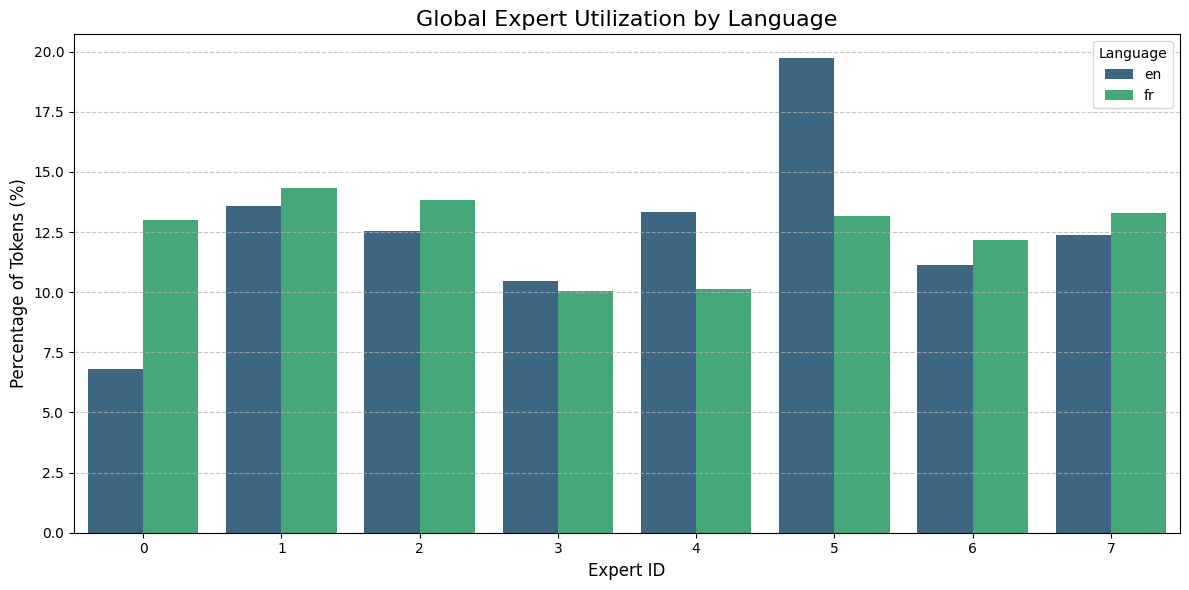

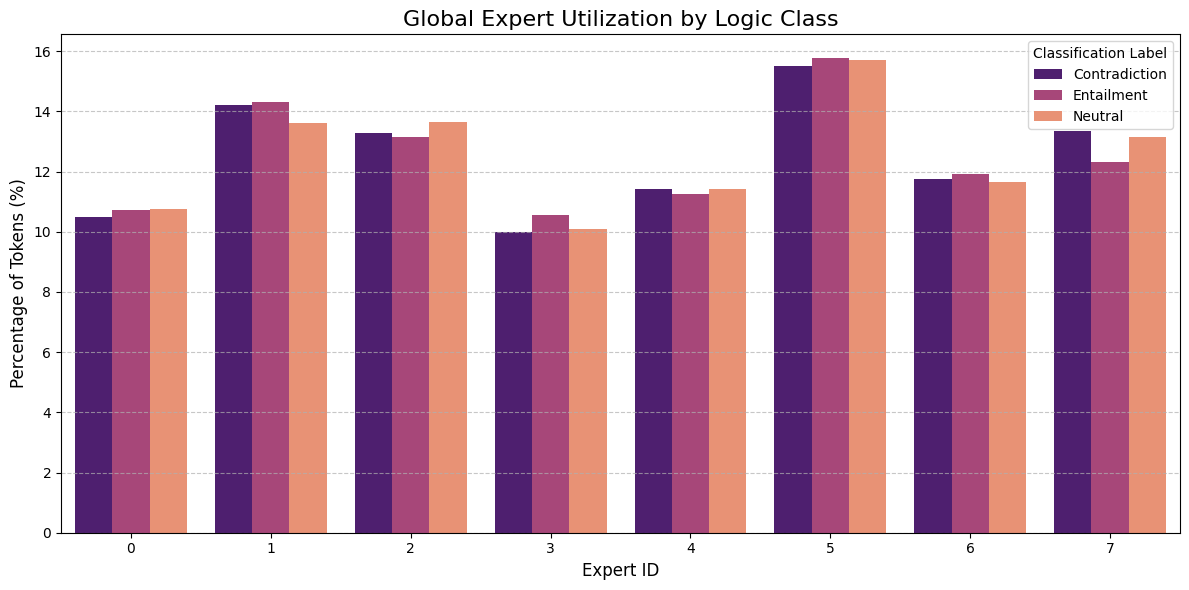

In [22]:
class RouterContext:
    def __init__(self):
        self.lang = None
        self.label_id = None

def visualize_expert_bargraphs(model, loaders, target_langs=['en', 'fr']):
    print("\n" + "="*50)
    print("COLLECTING DATA FOR BAR GRAPHS...")
    print("="*50)

    model.eval()
    ctx = RouterContext()

    # Storage: List of dictionaries for easy DataFrame conversion
    # We will record every single token routing event
    records = []

    # --- 1. Hook Definition ---
    def get_hook(layer_idx):
        def hook(module, input, output):
            indices = output[1].flatten().cpu().numpy()
            if ctx.lang is not None and ctx.label_id is not None:
                # Store aggregated counts per batch to save memory
                # (instead of appending every single token individually)
                unique, counts = np.unique(indices, return_counts=True)
                for expert_idx, count in zip(unique, counts):
                    records.append({
                        'Layer': layer_idx,
                        'Expert': expert_idx,
                        'Language': ctx.lang,
                        'Label_ID': ctx.label_id,
                        'Count': count
                    })
        return hook

    # --- 2. Attach Hooks ---
    handles = []
    for i, layer in enumerate(model.transformer.h):
        if hasattr(layer.mlp, 'router'):
            handles.append(layer.mlp.router.register_forward_hook(get_hook(i)))

    # --- 3. Inference Loop ---
    with torch.no_grad():
        for lang in target_langs:
            if lang not in loaders: continue
            print(f"Sampling {lang.upper()}...")

            # Sample ~200 batches
            for i, batch in enumerate(loaders[lang]):
                if i >= 200: break

                input_ids = batch["input_ids"].to(model.device)
                attention_mask = batch["attention_mask"].to(model.device)
                labels = batch["label_strs"]

                ctx.lang = lang

                label_val = int(labels[0])
                if label_val in [0, 1, 2]:
                    ctx.label_id = label_val

                model(input_ids=input_ids, attention_mask=attention_mask)

    # Cleanup
    for h in handles: h.remove()

    # --- 4. Process Data with Pandas ---
    print("Processing Data...")
    df = pd.DataFrame(records)

    # Map Label IDs to Names
    label_map = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}
    df['Label'] = df['Label_ID'].map(label_map)

    # =========================================================
    # PLOT 1: LANGUAGE UTILIZATION (Global)
    # =========================================================
    # Sum counts over all Layers and Labels
    lang_df = df.groupby(['Expert', 'Language'])['Count'].sum().reset_index()

    # Calculate Percentages per Language (Normalize)
    # "Of all tokens in English, what % went to Expert X?"
    lang_totals = lang_df.groupby('Language')['Count'].transform('sum')
    lang_df['Percentage'] = (lang_df['Count'] / lang_totals) * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(data=lang_df, x='Expert', y='Percentage', hue='Language', palette='viridis')

    plt.title('Global Expert Utilization by Language', fontsize=16)
    plt.ylabel('Percentage of Tokens (%)', fontsize=12)
    plt.xlabel('Expert ID', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Language')
    plt.tight_layout()
    plt.show()

    # =========================================================
    # PLOT 2: CLASSIFICATION UTILIZATION (Global)
    # =========================================================
    # Sum counts over all Layers and Languages
    class_df = df.groupby(['Expert', 'Label'])['Count'].sum().reset_index()

    # Calculate Percentages per Label
    # "Of all Entailment tokens, what % went to Expert X?"
    class_totals = class_df.groupby('Label')['Count'].transform('sum')
    class_df['Percentage'] = (class_df['Count'] / class_totals) * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(data=class_df, x='Expert', y='Percentage', hue='Label', palette='magma')

    plt.title('Global Expert Utilization by Logic Class', fontsize=16)
    plt.ylabel('Percentage of Tokens (%)', fontsize=12)
    plt.xlabel('Expert ID', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Classification Label')
    plt.tight_layout()
    plt.show()

finetuned_model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned-fr', device='cuda')
finetuned_model.eval()

visualize_expert_bargraphs(finetuned_model, all_test_loader, target_langs=['en', 'fr'])
del finetuned_model
torch.cuda.empty_cache()

## Multi Language Finetune

In [14]:
load_path = f'{save_base_path}/gpt2-moe-finetuned'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned', DEVICE)
tokenizer = GPT2Tokenizer.from_pretrained(f'{save_base_path}/gpt2-moe-finetuned')
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned


In [15]:
from torch.utils.data import ConcatDataset

"""
Load NLI datasets for fine-tuning and evaluation on multiple non-english splits.
Final training and evaluation should use the full dataset (SUBSET=1).
"""

target_langs = ["en", "fr", "es"]

train_datasets = []
for l in target_langs:
    ds = XNLIDataset(
        split="train",
        lang=l,
        tokenizer=tokenizer,
        subset=1.0
    )
    train_datasets.append(ds)

combined_train_dataset = ConcatDataset(train_datasets)

train_loader = DataLoader(
    combined_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=XNLIDataset.collate_fn
)

dev_datasets = []
for l in target_langs:
    ds = XNLIDataset(
        split="dev",
        lang=l,
        tokenizer=tokenizer,
        subset=1.0
    )
    dev_datasets.append(ds)

combined_dev_dataset = ConcatDataset(dev_datasets)

dev_loader = DataLoader(
    combined_dev_dataset,
    shuffle=False,
    collate_fn=XNLIDataset.collate_fn
)

Dataset initialized: split='train', lang='en', total=392702, subset=1.0, subset_count=392702
Dataset initialized: split='train', lang='fr', total=392702, subset=1.0, subset_count=392702
Dataset initialized: split='train', lang='es', total=392702, subset=1.0, subset_count=392702
Dataset initialized: split='dev', lang='en', total=2490, subset=1.0, subset_count=2490
Dataset initialized: split='dev', lang='fr', total=2490, subset=1.0, subset_count=2490
Dataset initialized: split='dev', lang='es', total=2490, subset=1.0, subset_count=2490


In [16]:
VOCAB_SIZE = tokenizer.vocab_size

criterion = torch.nn.CrossEntropyLoss()
# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, correct_bias=CORRECT_BIAS)
# Track training progress
global_train_losses = []
total_train_loss = 0.0
total_train_steps = 0
print_interval = 10

# Track best dev accuracy for model saving
# This only works for epoch > 1
best_dev_acc = 0.0
SAVE_DIR = "best_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()

    # Iterate over batches
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch.get("labels").to(DEVICE)

        optimizer.zero_grad()

        # 1. Forward pass to get hidden states
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        vocabulary_logits = outputs.logits

        # 3. Shift logits and labels for next-token prediction
        shifted_logits = vocabulary_logits[:, :-1, :].contiguous()
        shifted_labels = labels[:, 1:].contiguous()

        # Flatten for CrossEntropyLoss
        logits_for_loss = shifted_logits.view(-1, VOCAB_SIZE)
        labels_for_loss = shifted_labels.view(-1)

        # 4. Compute Language Modeling Loss
        lm_loss = criterion(logits_for_loss, labels_for_loss)

        # 5. --- FIX: Add Load Balancing Auxiliary Loss ---
        total_aux_loss = 0.0
        for module in model.modules():
            if isinstance(module, MoELayer):
                total_aux_loss += module.aux_loss

        # Combine losses
        loss = lm_loss + total_aux_loss

        # 6. Backpropagation
        loss.backward()
        optimizer.step()

        # Update stats
        total_train_loss += loss.item()
        total_train_steps += 1
        global_train_avg_loss = total_train_loss / total_train_steps
        global_train_losses.append(global_train_avg_loss)

        loop.set_postfix({
            'avg_loss': f"{global_train_avg_loss:.4f}",
            'aux_loss': f"{total_aux_loss:.4f}" # Optional: Monitor aux loss separately
        })

    print(f"Epoch {epoch+1} finished | Global Avg Loss: {global_train_avg_loss:.4f}")

    # Evaluation
    acc, all_preds, all_labels = evaluate_gpt2_xnli(model, tokenizer, dev_loader, max_gen_length=1, device=DEVICE)

    # Save model
    save_moe_model(model, f'{save_base_path}/gpt2-moe-finetuned-en-es-fr')
    tokenizer.save_pretrained(f'{save_base_path}/gpt2-moe-finetuned-en-es-fr')

    print("Model finetuned on XNLI EN split has been saved to ./gpt2-moe-finetuned-en-es-fr")
    print(f"The accuracy of this model is: {acc}")

Epoch 1/1


Training: 100%|██████████| 294527/294527 [13:59:36<00:00,  5.85it/s, avg_loss=0.7982, aux_loss=0.0597]


Epoch 1 finished | Global Avg Loss: 0.7982


Generating: 100%|██████████| 7470/7470 [05:47<00:00, 21.51it/s]


Evaluation accuracy: 69.91%
Model saved to /content/drive/MyDrive/MoE/gpt2-moe-finetuned-en-es-fr
Model finetuned on XNLI EN split has been saved to ./gpt2-moe-finetuned-en-es-fr
The accuracy of this model is: 0.6990629183400268


In [19]:
finetuned_model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned-en-es-fr', device='cuda')
finetuned_model.eval()
tokenizer = GPT2Tokenizer.from_pretrained(f'{save_base_path}/gpt2-moe-finetuned-en-es-fr')

all_test_loader = {}

for l in langs:
    test_dataset = XNLIDataset(split="test", lang=l, tokenizer=tokenizer, max_length=1024, subset=TEST_SUBSET)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=XNLIDataset.collate_fn)
    all_test_loader[l] = test_loader

all_results = {}

for test_lang in langs:
    test_loader = all_test_loader[test_lang]

    if test_lang in target_langs:
        print(f"Evaluating on {test_lang}...")
    else:
        print(f"Evaluating zero-shot on {test_lang}...")

    acc, all_preds, all_labels = evaluate_gpt2_xnli(finetuned_model, tokenizer, test_loader, max_gen_length=1, device=DEVICE)

    all_results[test_lang] = acc

print(f"\nResults for model trained on {target_langs}:")
for l, acc in all_results.items():
    print(f"{l}: {acc*100:.2f}%")

Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-en-es-fr
Dataset initialized: split='test', lang='en', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ar', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='bg', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='de', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='el', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='es', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='fr', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='hi', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ru', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='sw', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='th', total=5010, subset=1,

Generating: 100%|██████████| 5010/5010 [03:48<00:00, 21.94it/s]


Evaluation accuracy: 75.31%
Evaluating zero-shot on ar...


Generating: 100%|██████████| 5010/5010 [03:52<00:00, 21.57it/s]


Evaluation accuracy: 35.11%
Evaluating zero-shot on bg...


Generating: 100%|██████████| 5010/5010 [03:56<00:00, 21.16it/s]


Evaluation accuracy: 34.75%
Evaluating zero-shot on de...


Generating: 100%|██████████| 5010/5010 [03:51<00:00, 21.61it/s]


Evaluation accuracy: 47.05%
Evaluating zero-shot on el...


Generating: 100%|██████████| 5010/5010 [03:55<00:00, 21.31it/s]


Evaluation accuracy: 35.53%
Evaluating on es...


Generating: 100%|██████████| 5010/5010 [03:52<00:00, 21.50it/s]


Evaluation accuracy: 67.11%
Evaluating on fr...


Generating: 100%|██████████| 5010/5010 [03:53<00:00, 21.47it/s]


Evaluation accuracy: 65.49%
Evaluating zero-shot on hi...


Generating: 100%|██████████| 5010/5010 [03:57<00:00, 21.13it/s]


Evaluation accuracy: 36.19%
Evaluating zero-shot on ru...


Generating: 100%|██████████| 5010/5010 [03:58<00:00, 21.05it/s]


Evaluation accuracy: 34.79%
Evaluating zero-shot on sw...


Generating: 100%|██████████| 5010/5010 [03:51<00:00, 21.67it/s]


Evaluation accuracy: 41.22%
Evaluating zero-shot on th...


Generating: 100%|██████████| 5010/5010 [04:03<00:00, 20.60it/s]


Evaluation accuracy: 35.71%
Evaluating zero-shot on tr...


Generating: 100%|██████████| 5010/5010 [03:51<00:00, 21.61it/s]


Evaluation accuracy: 42.20%
Evaluating zero-shot on ur...


Generating: 100%|██████████| 5010/5010 [03:56<00:00, 21.18it/s]


Evaluation accuracy: 34.33%
Evaluating zero-shot on vi...


Generating: 100%|██████████| 5010/5010 [03:56<00:00, 21.23it/s]


Evaluation accuracy: 36.11%
Evaluating zero-shot on zh...


Generating: 100%|██████████| 5010/5010 [03:57<00:00, 21.11it/s]

Evaluation accuracy: 35.11%

Results for model trained on ['en', 'fr', 'es']:
en: 75.31%
ar: 35.11%
bg: 34.75%
de: 47.05%
el: 35.53%
es: 67.11%
fr: 65.49%
hi: 36.19%
ru: 34.79%
sw: 41.22%
th: 35.71%
tr: 42.20%
ur: 34.33%
vi: 36.11%
zh: 35.11%


Model loaded from /content/drive/MyDrive/MoE/gpt2-moe-finetuned-en-es-fr

COLLECTING DATA FOR BAR GRAPHS...
Sampling EN...
Sampling FR...
Sampling ES...
Processing Data...


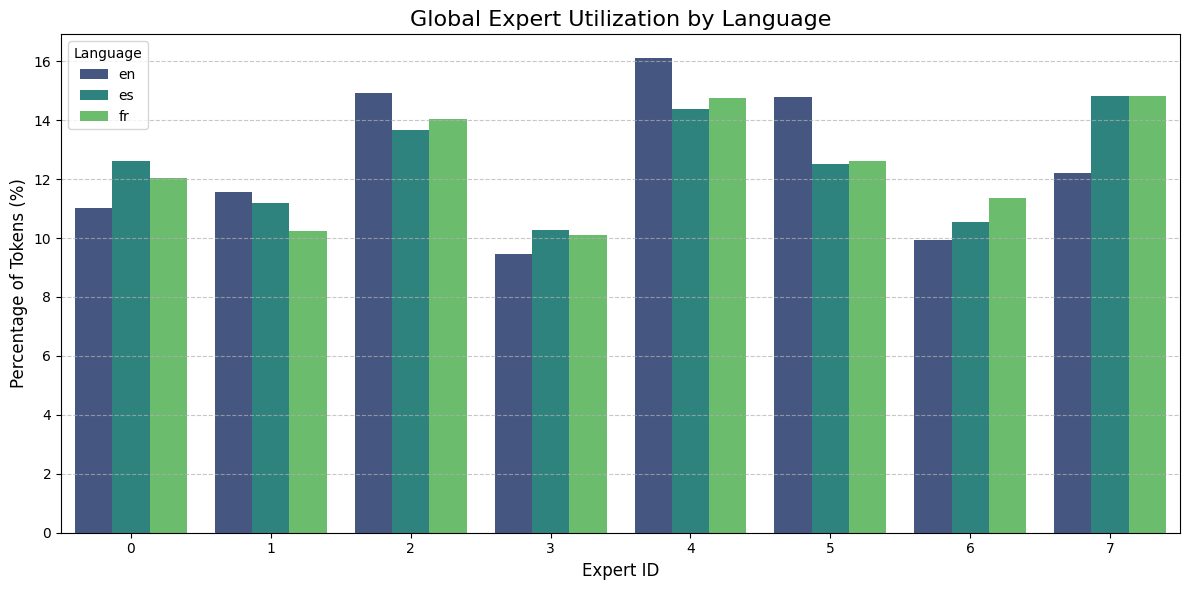

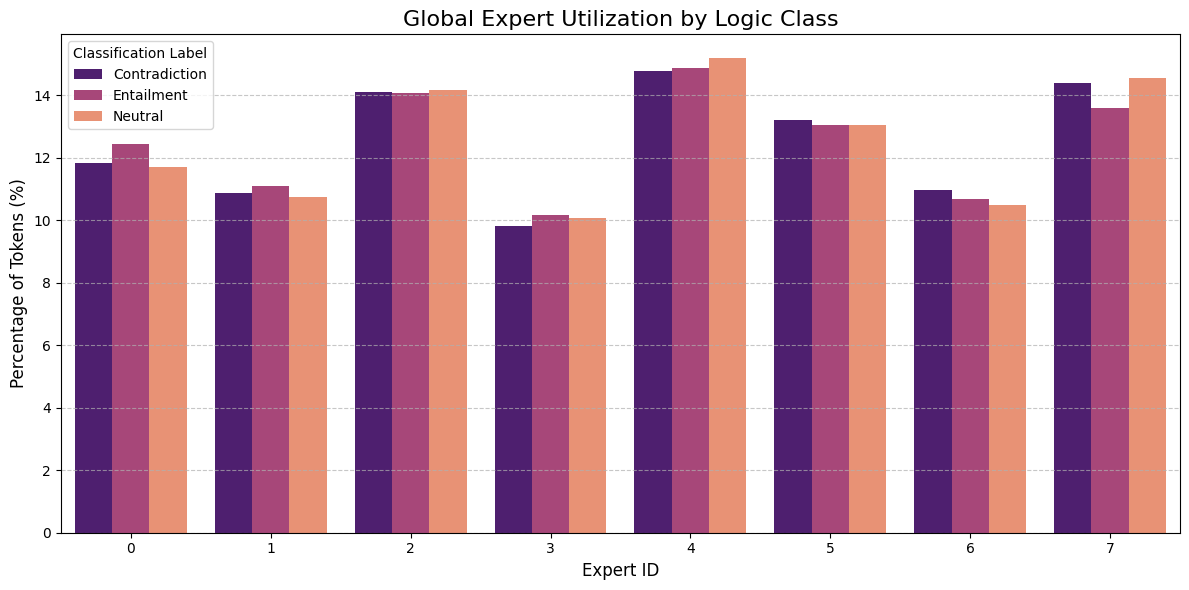

In [23]:
finetuned_model = load_moe_model(f'{save_base_path}/gpt2-moe-finetuned-en-es-fr', device='cuda')
finetuned_model.eval()

visualize_expert_bargraphs(finetuned_model, all_test_loader, target_langs=target_langs)
del finetuned_model
torch.cuda.empty_cache()